# Build subytpes on ABIDE TDC
The point of this notebook is to build subtypes on healthy ABIDE subjects using the three methods I have (scores, dureg and seed) and then to compare these subtypes on a test retest dataset like NYU or NKI.

For now I do everything at __scale 12__.

In [46]:
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
%matplotlib inline

In [3]:
# Variables
scale = 12
tpl = '*_fmri_{:07d}_session_1_run1_stability_maps.nii.gz'
mtp = 'stability_maps'
# Paths
pheno_path = '/data1/abide/Pheno/existing_pheno.csv'
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03}.nii.gz'.format(scale)
data_path = '/data1/abide/Out/Scores/sc{}/time'.format(scale)
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
out_path = '/data1/subtypes/sc12'

## Build the list of health subjects
The subtypes should be based only on healthy subjects - maybe it would make sense to also constrain them by motion.

In [4]:
pheno = pd.read_csv(pheno_path)

In [5]:
pheno.head()

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,frames_scrubbed,frames_OK,FD,FD_scrubbed
0,CALTECH,51456,1,4,55.4,1,R,NaN,126,118,...,NaN,NaN,NaN,2,NaN,NaN,95,55,0.434593,0.328121
1,CALTECH,51457,1,4,22.9,1,Ambi,NaN,107,119,...,NaN,NaN,NaN,2,NaN,NaN,16,134,0.207160,0.170893
2,CALTECH,51458,1,1,39.2,1,R,NaN,93,80,...,NaN,NaN,NaN,2,NaN,NaN,18,132,0.322805,0.288872
3,CALTECH,51459,1,1,22.8,1,R,NaN,106,94,...,NaN,NaN,NaN,2,NaN,NaN,0,150,0.152963,0.152963
4,CALTECH,51460,1,1,34.6,2,Ambi,NaN,133,135,...,NaN,NaN,NaN,2,NaN,NaN,0,150,0.207277,0.207277


We will go by the variable `DX_GROUP` which is 1 for patients and 2 for controls.

In [6]:
# Get the controls
controls = (pheno['DX_GROUP'] == 2).values
# Find how many there are
n_controls = np.sum(controls)
# constrain the pheno data to the controls
pheno_controls = pheno[controls]

## Prepare the subtype
We will load the mask and the priors and then prepare the subject by subject similarity matrix

In [7]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [8]:
# Prepare the list of paths to the files
path_list = [glob.glob(os.path.join(data_path, mtp, tpl.format(r['SUB_ID'])))[0] for i, r in pheno_controls.iterrows()]

In [22]:
# Prepare storage
n_voxel = np.sum(mask)
m_store = np.zeros((n_voxel, scale, n_controls))

# Loop through the subjects and get their maps
timer = bb.tools.Counter(n_controls)
for s_id, s_path in enumerate(path_list):
    timer.tic()
    m_store[..., s_id] = nib.load(s_path).get_data()[mask]
    timer.toc()
    timer.progress()

# And then demean the stack
m_store += -np.tile(np.mean(m_store, 2)[..., None], (1, 1, n_controls))

 100.0 % done 0.00 seconds to go. One step takes 0.06318 and we ran for 27.17 s so far

## Do the subtype
Now we'll run the subject by subject correlation analysis for each network and then decide on the clustering

In [25]:
# Define variables
simmat_store = np.zeros((n_controls, n_controls, scale))

# Iterate over the networks
timer = bb.tools.Counter(scale)
for sc_id in np.arange(scale):
    timer.tic()
    # Compute the subject by subject correlation matrix
    simmat_store[..., sc_id] = np.corrcoef(m_store[:, sc_id, :], rowvar=0)
    timer.toc()
    timer.progress()

 100.0 % done 0.00 seconds to go. One step takes 61.21746 and we ran for 795.83 s so far

In [31]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

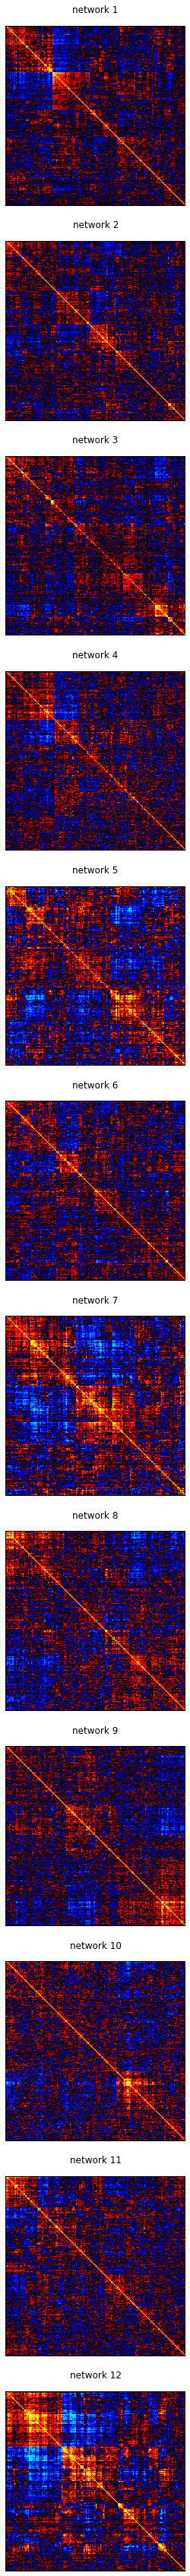

In [42]:
np.mean# Show the subtypes
rows = np.ceil(scale/3.0)
fig = plt.figure(figsize=(10,60))
gs = gridspec.GridSpec(scale, 1)
for sc_id in np.arange(scale):
    # get the linkage
    link_mat = scl.hierarchy.linkage(simmat_store[..., sc_id], method='ward')
    dend = scl.hierarchy.dendrogram(link_mat, no_plot=True)
    order = dend['leaves']
    tmp = simmat_store[..., sc_id][order, :]
    mat = tmp[:, order]
    ax = fig.add_subplot(gs[sc_id])
    ax.matshow(mat, vmin=-0.25, vmax=0.25, cmap=hotcold)
    ax.set_title('network {}'.format(sc_id + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

## Observations
Here are a number of things I notice when looking at these plots:

1. There are some networks with a good deal of struture in the ordered similarity matrices. This indicates that there are in fact __meaningful connectivity subtypes__ in these networks, I want to investigate them further.
* the similarity maps of some networks have a lot less structure than those of others. It even seems as if for these networks, there are __no meaningful subtypes__. It will be interesting to see what happens if we still extract subtypes from these networks. My assumption is that the networks that show this type of pattern are mostly primary sensory networks with little inter-subject variation.
* There seems to be a __multi-level organization__ going on in these matrices. As in, some subjects are part of a bigger subgroup within which they are part of a smaller, more similar subgroup. This is a visual feature of the colour map scaling and I need to check different colour map thresholds to see if this affects the networks for which this seems to be the case

Now for some network specific observations:
### Network 1
* There are two very distinct subgroups in the sample (both in the top left of the map). They are highly similar within and highly dissimilar between each other, while the association with everybody else seems to be roughly the same for both of them (at least there is no clear pattern there).
* Apart from these two subgroups, there seem to be two or three additional subgroups that are characterized by higher within than between similarity - but the contrast of within vs between is not particularly strong there. 
* A three cluster solution would probably identify the one on the left, an extended version of the second and then the rest on the right. _I'm not sure if doing a visual selection of clusters is really the way to go here, should probably talk with Pierre about this_.
### Network 2
* Here we have a rather clear separation of 3 clusters, with a possible fourth to the right plus a noise cluster with everyone who is kinda similar to everybody else.
* _I wonder how this works: having a clear separation between two clusters and then having other subjects that are more or less similar with both clusters. I don't get that. Need to ask Pierre_.
### Network 7
* Very clear and strong distinction into two subtypes
* The rest is less well differentiated.
### Network 12
* Very clear differentiation into two subgroups
* The rest is less clear to differentiate.